# Assignment 1: Experiments with Machine Learning
---
## Objective
* Assignment 1 explores the use of SciKit Learn libraries in python to perform sentiment analysis on a given text string dataset
    * The dataset used provides us with amazon reviews and whether the sentiment of the text is **Positive/Negative**
* The following Machine Learning models were used:
    * **Naive-Bayes classifier**
    * **Decision Tree classifier**
---
## How to Run
1. Download all files contained in package
2. Open **Anaconda** and run **Jupyter Notebook**
3. Navigate to directory containing the assignment files
4. Open ```Assignment_1.ipynb```
5. Select the following options from the toolbar
> Cell   \> Run All

---
## Troubleshooting Issues
* The most likely issue is a missing library

### NLTK not Found
* The **NLTK** Library does *not* come installed with Anaconda
* Visit the [NLTK Installation Page](https://www.nltk.org/install.html)
* What is NLTK?
    * NLTK is a **N**atural **L**anguage **P**rocessing **T**oolkit
    * NLTK has functions to help us clean our text and remove unnecessary words/punctuation

---

# I: Importing Necessary Modules
* We start by first importing the necessary modules and setting global parameters

In [2]:
# Define imports and global variables

import re
import numpy as np
import nltk
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import string
import os
import shutil
from __future__ import division
from codecs import open
from collections import Counter
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import plot_confusion_matrix
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

dataset_filename = "all_sentiment_shuffled"
dataset_paths = {}

SyntaxError: from __future__ imports must occur at the beginning of the file (<ipython-input-2-14703c000592>, line 15)

---


# II: Function Definitions
* Defining various functions to be used throughout the notebook

In [2]:
# Define utils functions.

# Read raw data file, splits into labels and documents.

def read_documents(doc_file):
    docs = []
    labels = []
    with open(doc_file, encoding='utf-8') as f:
        for line in f:
            words = line.strip().split()
            docs.append(words[3:])
            labels.append(words[1])
    return docs, labels

# Calculates the prior probability of an array using Counter.

def compute_prior_probabilities(labels):
    result = {}
    labels_distribution = Counter(labels)
    for label, count in labels_distribution.items():
        prior = labels_distribution[label] / len(labels)
        result[label] = round(prior, 3)
    return result

def print_accuracy_report(model,report,accuracy,df):
    path = dataset_paths.get(model)
    os.chdir(path)
    with open(model+"-AccuracyReport.txt","w+") as file:
        file.write("|-----------------------"+model+" Accuracy report"+"-----------------------|")
        file.write("\n\n(c) Precision, Recall, and F1-Measure for each class given by: \n")
        file.write(report)
        file.write("\n(d) Overall Model Accuracy: \t"+str(accuracy))
        file.write("\n\n\n|----------------"+model+" Row Number and Predicted Class"+"----------------|")
        file.write("\n\n(a) Row number of each instance and the index of its predicted class:\n\n")
        for index, row in df.iterrows():
            file.write(str(index)+","+row[0]+"\n")
    os.chdir("..")

def generate_output_files():
    models = ["NaiveBayes","BaseDT","BestDT"]
    for model in models:
        path = model + "-" +dataset_filename
        dataset_paths.update({model:path})
        if os.path.exists(path):
            shutil.rmtree(path)
        os.makedirs(path)

---
# III: Loading the Dataset, Data Pre-Processing, and Data Visualization
* Before running a model, we must first:
    * **Load the dataset** into our program
    * **Pre-Process** and clean the text in the dataset
    * **Visualize our data** using plots and examining prior probabilities

In [3]:
# TASK 0
# Read raw content file and split into documents and labels.

all_docs, all_labels = read_documents(dataset_filename+".txt")
generate_output_files()
print("Examining the Raw Data: \n")
print(all_docs[:5])

# Cleaning words from dataset - Removing stopwords, punctuation, whitespaces, etc.

stop_words = set(stopwords.words("english"))
punctuation_table = str.maketrans("","",string.punctuation)

for i in range(len(all_docs)):
    all_docs[i] = [word.lower() for word in all_docs[i]]
    all_docs[i] = [word.translate(punctuation_table) for word in all_docs[i]]
    all_docs[i] = [word.replace(" ","") for word in all_docs[i]]
    all_docs[i] = [word for word in all_docs[i] if word != '']
    all_docs[i] = [word for word in all_docs[i] if not word in stop_words]
    all_docs[i] = [word for word in all_docs[i] if not word.isdigit()]

Examining the Raw Data: 

[['i', 'bought', 'this', 'album', 'because', 'i', 'loved', 'the', 'title', 'song', '.', 'it', "'s", 'such', 'a', 'great', 'song', ',', 'how', 'bad', 'can', 'the', 'rest', 'of', 'the', 'album', 'be', ',', 'right', '?', 'well', ',', 'the', 'rest', 'of', 'the', 'songs', 'are', 'just', 'filler', 'and', 'are', "n't", 'worth', 'the', 'money', 'i', 'paid', 'for', 'this', '.', 'it', "'s", 'either', 'shameless', 'bubblegum', 'or', 'oversentimentalized', 'depressing', 'tripe', '.', 'kenny', 'chesney', 'is', 'a', 'popular', 'artist', 'and', 'as', 'a', 'result', 'he', 'is', 'in', 'the', 'cookie', 'cutter', 'category', 'of', 'the', 'nashville', 'music', 'scene', '.', 'he', "'s", 'gotta', 'pump', 'out', 'the', 'albums', 'so', 'the', 'record', 'company', 'can', 'keep', 'lining', 'their', 'pockets', 'while', 'the', 'suckers', 'out', 'there', 'keep', 'buying', 'this', 'garbage', 'to', 'perpetuate', 'more', 'garbage', 'coming', 'out', 'of', 'that', 'town', '.', 'i', "'ll", 'get

In [4]:
# Split documents and labels into training (80%) and evaluation sets (20%).

train_docs, eval_docs, train_labels, eval_labels = train_test_split(all_docs, all_labels, test_size = 0.20, random_state = 12)

# Taking a look at some data samples to see what we have 
print("First 5 dataset entries: \n") 
print(all_docs[:5])

print("\n\nFirst 5 label entries: \n")
print("\n".join(all_labels[:5]))

First 5 dataset entries: 

[['bought', 'album', 'loved', 'title', 'song', 'great', 'song', 'bad', 'rest', 'album', 'right', 'well', 'rest', 'songs', 'filler', 'nt', 'worth', 'money', 'paid', 'either', 'shameless', 'bubblegum', 'oversentimentalized', 'depressing', 'tripe', 'kenny', 'chesney', 'popular', 'artist', 'result', 'cookie', 'cutter', 'category', 'nashville', 'music', 'scene', 'gotta', 'pump', 'albums', 'record', 'company', 'keep', 'lining', 'pockets', 'suckers', 'keep', 'buying', 'garbage', 'perpetuate', 'garbage', 'coming', 'town', 'get', 'soapbox', 'country', 'music', 'really', 'needs', 'get', 'back', 'roots', 'stop', 'pop', 'nonsense', 'country', 'music', 'really', 'considered', 'mainstream', 'two', 'different', 'things'], ['misled', 'thought', 'buying', 'entire', 'cd', 'contains', 'one', 'song'], ['introduced', 'many', 'ell', 'high', 'school', 'students', 'lois', 'lowery', 'depth', 'characters', 'brilliant', 'writer', 'capable', 'inspiring', 'fierce', 'passion', 'readers', 

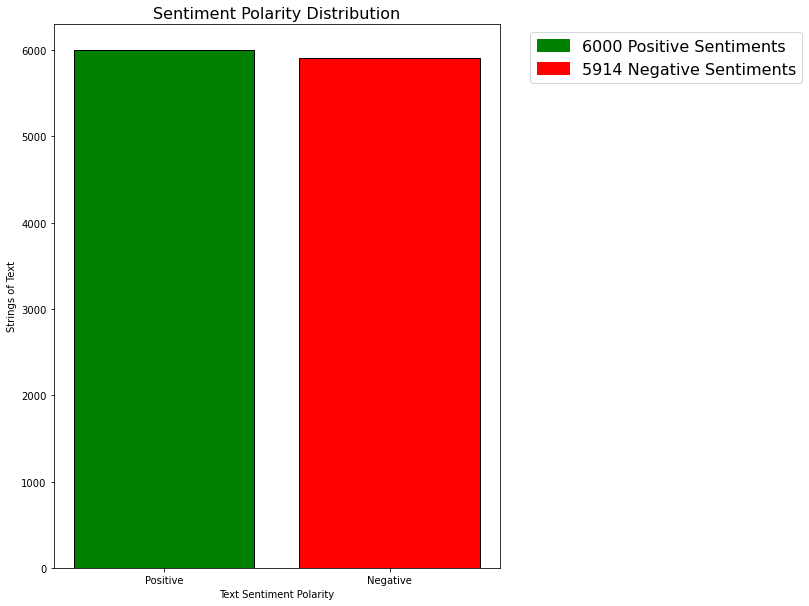

,Class,Number of instances
0,neg,5914
1,pos,6000


In [5]:
# TASK 1
# Plot the distribution of the number of the instances in each class.


# Bar Chart

# counting all postive/negative instances
pos_count = 0
neg_count = 0

posneg_count = Counter(all_labels)

pos_count = posneg_count["pos"]
neg_count = posneg_count["neg"]

# Chart parameters (colors, titles, data)
label = ("Positive","Negative")
label_counts = [pos_count,neg_count]
colors = ["green","red"]
y_pos = np.arange(len(label_counts))

# Legend for bar chart
green_patch = mpatches.Patch(color="green",label=str(pos_count)+" Positive Sentiments")
red_patch = mpatches.Patch(color="red",label=str(neg_count)+" Negative Sentiments")

# Bar chart formatting and plotting
plt.rcParams["figure.figsize"] = (8,10)
plt.bar(y_pos, label_counts, color=colors, edgecolor="black")
plt.xticks(y_pos, label)
    
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.xlabel("Text Sentiment Polarity")
plt.ylabel("Strings of Text")
plt.title("Sentiment Polarity Distribution")
plt.legend(handles=[green_patch,red_patch],bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


# Table

table = pd.DataFrame(posneg_count.items(), columns=["Class", "Number of instances"]) 
table

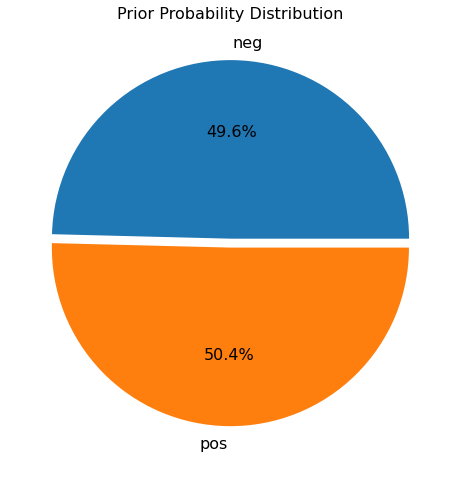

,Class,Prior Probability
0,neg,0.496
1,pos,0.504


In [6]:
# TASK 1
# Calculate the prior probability of the labels (will not be directly used, just for explanation).

prior_probability = compute_prior_probabilities(all_labels)

# Plot prior probability in pie chat.

plt.pie(prior_probability.values(), labels=prior_probability.keys(),explode = (0.05,0), autopct='%1.1f%%')
plt.title("Prior Probability Distribution")
plt.show()

# Plot prior probability in table.

table = pd.DataFrame(prior_probability.items(), columns=["Class", "Prior Probability"]) 
table

---
# IV: Applying ML Models to our Dataset
* Our data is now properly prepared and ready to be subjected to a model
* The process used to apply the model and test the output is as follows:
    1. **Vectorize** the data
    2. **Fit the vectorized data** to a model Pipeline
    3. **Test** the model using our evaluation data
    4. **Sanity check** to make sure our results make sense
    
    
* We will examine various properties of the model, including:
    * **Accuracy**
    * **The Confusion Matrix**
    * **Precision**
    * **Recall**
    * **F1 Precision**
* The same process will be repeated for each model
---
# IV (a): Naive-Bayes Classifier

In [7]:
# Preparing dataset for vectorization (i.e. joining words by whitespace into one sentence)

train_docs = [" ".join(x) for x in train_docs]
eval_docs = [" ".join(x) for x in eval_docs]

In [8]:
# TASK 3a - NB
# Vectorize training documents (will not be directly used, just for explanation).
# Using pipeline instead.

vectorizer = TfidfVectorizer()
vectorized_docs = vectorizer.fit_transform(train_docs)

# Show vectorized words
table = pd.DataFrame(vectorizer.vocabulary_.items(), columns=["Word", "Vector"]) 
table

,Word,Vector
0,around,2836
1,awesome,3522
2,product,32153
3,great,18050
4,experiences,14692
...,...,...
46525,yorequot,46286
46526,morbidly,26722
46527,taupin,40884
46528,kindred,22719


In [9]:
# TASK 3a - NB
# Vectorize then use Naive Bayes Multinomial model to train.

classifier = Pipeline( [ ( 'vec', TfidfVectorizer() ), ( 'cls', MultinomialNB(alpha=1.0) ) ] )
classifier.fit(train_docs, train_labels)

Pipeline(steps=[('vec', TfidfVectorizer()), ('cls', MultinomialNB())])

In [10]:
# TASK 3a - NB
# Predict result of evaluation data set.

prediction_result = classifier.predict(eval_docs)

In [11]:
# Task 3a - NB
# The row number of the instance, followed by a comma, followed by the index of the predicted class of that instance.


df = pd.DataFrame(prediction_result)
df.columns = ["Prediction"]
df

,Prediction
0,neg
1,neg
2,pos
3,pos
4,pos
...,...
2378,pos
2379,pos
2380,pos
2381,pos


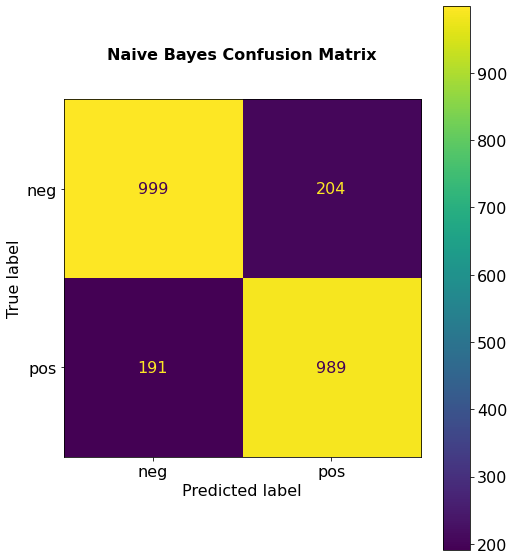

In [12]:
# TASK 3a - NB
# Confusion Matrix

plot_confusion_matrix(classifier, eval_docs, eval_labels)


# Saving plot to output file

path = dataset_paths.get("NaiveBayes")
os.chdir(path)
plt.title("Naive Bayes Confusion Matrix",pad=40,fontweight="bold")
plt.savefig("NaiveBayes-ConfusionMatrix.pdf")
os.chdir("..")


plt.show() 

In [13]:
# TASK 3a - NB
# The precision, recall, and f1-measure for each class

report = classification_report(eval_labels, prediction_result)
print(report)

              precision    recall  f1-score   support

         neg       0.84      0.83      0.83      1203
         pos       0.83      0.84      0.83      1180

    accuracy                           0.83      2383
   macro avg       0.83      0.83      0.83      2383
weighted avg       0.83      0.83      0.83      2383



In [14]:
# TASK 3a - NB
# Accuracy score.

accuracy = accuracy_score(eval_labels, prediction_result)*100
print("Prediction accuracy score is ", accuracy , "%")

# Printing output files

print_accuracy_report("NaiveBayes",report,accuracy,df)

Prediction accuracy score is  83.4242551405791 %


In [15]:
# Naive Bayes Sanity Check

sanity_check_prediction_result = classifier.predict(['bad','good','great','worst','love'])
print(classification_report(['neg','pos','pos','neg', 'pos'], sanity_check_prediction_result))

              precision    recall  f1-score   support

         neg       1.00      1.00      1.00         2
         pos       1.00      1.00      1.00         3

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5



In [16]:
# Naive Bayes Sanity Check
# Prediction score based on sanity check evaluation labels.

print("Prediction accuracy score is ", round(accuracy_score(['neg','pos','pos','neg', 'pos'], sanity_check_prediction_result), 2)*100 , "%")

Prediction accuracy score is  100.0 %


---
# IV (b): Base Decision Tree Classifier

In [17]:
# TASK 3b - Base DT
# Vectorize then use Base DT model to train.

base_dt_classifier = Pipeline( [ ( 'vec', TfidfVectorizer() ), ( 'clf', DecisionTreeClassifier(criterion='entropy') ) ] )
base_dt_classifier.fit(train_docs, train_labels)

Pipeline(steps=[('vec', TfidfVectorizer()),
                ('clf', DecisionTreeClassifier(criterion='entropy'))])

In [18]:
# TASK 3b - Base DT
# Predict result of evaluation data set.

base_dt_prediction_result = base_dt_classifier.predict(eval_docs)

In [19]:
# Task 3b - Base DT
# The row number of the instance, followed by a comma, followed by the index of the predicted class of that instance.

df = pd.DataFrame(base_dt_prediction_result)
df

,0
0,pos
1,neg
2,neg
3,pos
4,pos
...,...
2378,neg
2379,neg
2380,pos
2381,neg


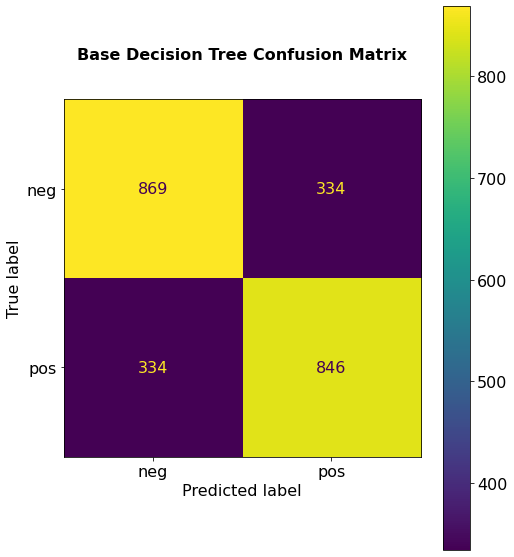

In [20]:
# TASK 3b - Base DT
# Confusion Matrix

plot_confusion_matrix(base_dt_classifier, eval_docs, eval_labels )  


# Saving plot to output file

path = dataset_paths.get("BaseDT")
os.chdir(path)
plt.title("Base Decision Tree Confusion Matrix",pad=40,fontweight="bold")
plt.savefig("BaseDT-ConfusionMatrix.pdf")
os.chdir("..")


plt.show() 

In [21]:
# TASK 3b - Base DT
# The precision, recall, and f1-measure for each class

report = classification_report(eval_labels, base_dt_prediction_result)
print(report)

              precision    recall  f1-score   support

         neg       0.72      0.72      0.72      1203
         pos       0.72      0.72      0.72      1180

    accuracy                           0.72      2383
   macro avg       0.72      0.72      0.72      2383
weighted avg       0.72      0.72      0.72      2383



In [22]:
# TASK 3b - Base DT
# Accuracy score.

accuracy = accuracy_score(eval_labels, base_dt_prediction_result)*100
print("Prediction accuracy score is ", accuracy , "%")

# Printing output file

print_accuracy_report("BaseDT",report,accuracy,df)

Prediction accuracy score is  71.96810742761225 %


In [23]:
# Base DT Sanity Check

base_dt_sanity_check_prediction_result = base_dt_classifier.predict(['bad','good','great','worst','love'])
print(classification_report(['neg','pos','pos','neg', 'pos'], base_dt_sanity_check_prediction_result))

              precision    recall  f1-score   support

         neg       1.00      1.00      1.00         2
         pos       1.00      1.00      1.00         3

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5



In [24]:
# Base DT Sanity Check
# Prediction score based on sanity check evaluation labels.

print("Prediction accuracy score is ", round(accuracy_score(['neg','pos','pos','neg', 'pos'], base_dt_sanity_check_prediction_result), 2)*100 , "%")

Prediction accuracy score is  100.0 %


---
# IV (c): Best Decision Tree Classifier

In [25]:
DT = DecisionTreeClassifier()
parameters = {
    "criterion":["gini","entropy"],
    "min_samples_split":range(7,15),
    "splitter":["best","random"]
}

vectorizer = TfidfVectorizer()
vectorizer.fit(train_docs)
vectorized_docs = vectorizer.transform(train_docs)

grid = GridSearchCV(DT,param_grid=parameters,cv=10,verbose=1,n_jobs=-1)
grid.fit(vectorized_docs,train_labels)

Fitting 10 folds for each of 32 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  1.9min finished


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'min_samples_split': range(7, 15),
                         'splitter': ['best', 'random']},
             verbose=1)

In [26]:
grid.best_params_

{'criterion': 'entropy', 'min_samples_split': 10, 'splitter': 'random'}

In [27]:
# TASK 3 - Best DT
# Vectorize then use Base DT model to train.

base_dt_classifier = Pipeline( [ ( 'vec', TfidfVectorizer() ), ( 'clf', DecisionTreeClassifier(criterion="entropy",min_samples_split=11,splitter="random") ) ] )

base_dt_classifier.fit(train_docs, train_labels)

Pipeline(steps=[('vec', TfidfVectorizer()),
                ('clf',
                 DecisionTreeClassifier(criterion='entropy',
                                        min_samples_split=11,
                                        splitter='random'))])

In [28]:
# TASK 3c - Best DT
# Predict result of evaluation data set.

base_dt_prediction_result = base_dt_classifier.predict(eval_docs)

In [29]:
# Task 3c - Best DT
# The row number of the instance, followed by a comma, followed by the index of the predicted class of that instance.


df = pd.DataFrame(base_dt_prediction_result)
df.columns = ["Prediction"]
df

,Prediction
0,pos
1,neg
2,pos
3,pos
4,pos
...,...
2378,neg
2379,neg
2380,neg
2381,pos


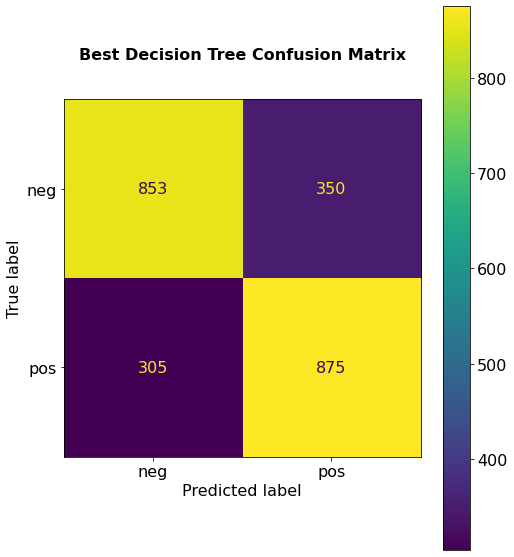

In [30]:
# TASK 3c - Best DT
# Confusion Matrix

plot_confusion_matrix(base_dt_classifier, eval_docs, eval_labels )  


# Saving plot to output file

path = dataset_paths.get("BestDT")
os.chdir(path)
plt.title("Best Decision Tree Confusion Matrix",pad=40,fontweight="bold")
plt.savefig("BestDT-ConfusionMatrix.pdf")
os.chdir("..")


plt.show() 

In [31]:
# TASK 3c - Best DT
# The precision, recall, and f1-measure for each class

report = classification_report(eval_labels, base_dt_prediction_result)
print(report)

              precision    recall  f1-score   support

         neg       0.74      0.71      0.72      1203
         pos       0.71      0.74      0.73      1180

    accuracy                           0.73      2383
   macro avg       0.73      0.73      0.73      2383
weighted avg       0.73      0.73      0.73      2383



In [32]:
# TASK 3c - Best DT
# Accuracy score.

accuracy = accuracy_score(eval_labels, base_dt_prediction_result)*100
print("Prediction accuracy score is ", accuracy , "%")

# Printing to output file

print_accuracy_report("BestDT",report,accuracy,df)

Prediction accuracy score is  72.51363827108686 %


In [33]:
# Best DT Sanity Check

base_dt_sanity_check_prediction_result = base_dt_classifier.predict(['bad','good','great','worst','love'])
print(classification_report(['neg','pos','pos','neg', 'pos'], base_dt_sanity_check_prediction_result))

              precision    recall  f1-score   support

         neg       1.00      1.00      1.00         2
         pos       1.00      1.00      1.00         3

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5



In [ ]:
# Best DT Sanity Check
# Prediction score based on sanity check evaluation labels.

print("Prediction accuracy score is ", round(accuracy_score(['neg','pos','pos','neg', 'pos'], base_dt_sanity_check_prediction_result), 2)*100 , "%")

# Task 4: Error Analysis
### printing some misclassified documents with the correct lable - predection

In [ ]:
#printing the misclassified documents:
data = {'real labels':eval_labels,'predictions':base_dt_prediction_result,'documents':eval_docs}
df = pd.DataFrame(data)
print(df[df['real labels']!=df['predictions']][:15].values)

# Explanation:
as we can see in the few examples, there are several reasons to misclassify a document:

- The use of so neutral language, spelling mistakes and the use of indirect wording: such as in this example: “nt aware swords existed noteworthy enough grace pages encyclopedia european seems much left ignoring eastern blades”
- data has too much noise: some reviewers were talking about previous experience or the backstory of the product ( why they need it) an example: “normally wouldnt write review numerous experiences camera thought would share sister first bought camera amazed user …”.
- Some reviews also describe what they liked and didn’t like about the product which can cause misclassifying the review example :”always fan star wars saga never really read novels first sw novel must say want sith finished novel last night…”